### How to run

It is sufficient to run all the cells until the paragraph "Run the algorithm", where we can change the working directory, choose the encoding settings, the input image and run it. The algorithm will look for the input image in the working directory and store the final result in there (you can set it below).

Usually these two packages are not installed by default

In [ ]:
pip install rawpy

In [ ]:
pip install memory_profiler

In [1]:
from PIL import Image
import os
import rawpy
from tqdm import tqdm
import numpy as np
import imageio
import pandas as pd
import math as mt
import cv2 as cv
from scipy.fftpack import dct, idct
from itertools import repeat, compress, groupby
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections as cl
import graphviz
from memory_profiler import memory_usage

# Functions

### Color Space Transform, Padding and Zigzag functions

In [2]:
#Round for Color Space Transformation
def jpeg_round(x):
    return np.ceil((x + .5)) 

#Image padding
def image_padding(channels, pad_type, pad_technique):
    
    #(we make image dimensions a multiple of 2)
    if pad_type == 'subsampling':
        #Extracting original shape of channels
        height = channels[0].shape[0]
        width = channels[0].shape[1]
        #Extracting channels
        Y = channels[0]
        Cb = channels[1]
        Cr = channels[2]

        #Using edge replication    
        if pad_technique == 'edge':
            if height % 2 != 0: #rows
                pad_y = Y[-1]
                Y = np.vstack([Y, pad_y])
                pad_cr = Cr[-1]
                Cr = np.vstack([Cr, pad_cr])
                pad_cb = Cb[-1]
                Cb = np.vstack([Cb, pad_cb])
                print('Added a row!')

            if width % 2 != 0: #columns
                pad_y = Y[:, -1:]
                Y = np.hstack([Y, pad_y])
                pad_cr = Cr[:, -1:]
                Cr = np.hstack([Cr, pad_cr])
                pad_cb = Cb[:, -1:]
                Cb = np.hstack([Cb, pad_cb])
                print('Added a column!')
        
        #Using zeros padding           
        elif pad_technique == 'zeros':
            if height % 2 != 0: #rows
                pad = np.zeros((1, len(Cr[0])))
                Y = np.vstack([Y, pad])
                Cr = np.vstack([Cr, pad])
                Cb = np.vstack([Cb, pad])
                print('Added a row!')

            if width % 2 != 0: #columns
                pad = np.zeros((len(Cr), 1))
                Y = np.hstack([Y, pad])
                Cr = np.hstack([Cr, pad])
                Cb = np.hstack([Cb, pad])
                print('Added a column!')

        else: raise ValueError('pad_technique must be either edge or zeros')
        return Y, Cb, Cr

    #We make image dimensions a multiple of 8 in order to apply DCT
    elif pad_type == 'dct':
        Y = channels[0]
        Cb_downsampled = channels[1]
        Cr_downsampled = channels[2]

        #Edge replication
        if pad_technique == 'edge':
            #Chrominance
            while Cr_downsampled.shape[0] % 8 != 0: #rows
                pad_cr = Cr_downsampled[-1]
                Cr_downsampled = np.vstack([Cr_downsampled, pad_cr])
                pad_cb = Cb_downsampled[-1]
                Cb_downsampled = np.vstack([Cb_downsampled, pad_cb])

            while Cr_downsampled.shape[1] % 8 != 0: #columns
                pad_cr = Cr_downsampled[:, -1:]
                Cr_downsampled = np.hstack([Cr_downsampled, pad_cr])
                pad_cb = Cb_downsampled[:, -1:]
                Cb_downsampled = np.hstack([Cb_downsampled, pad_cb])

            print("The new chrominance components shape is:", Cr_downsampled.shape)

            #Since we must keep the 1:2 proportion between the luminance component dimensions and the chrominance
            #component dimensions, we add rows/columns to the luminance component until the proportion is re-established

            while Cr_downsampled.shape[0] * 2 != Y.shape[0]: #rows
                pad = Y[-1]
                Y = np.vstack([Y, pad])
            while Cr_downsampled.shape[1] * 2 != Y.shape[1]: #columns
                pad = Y[:, -1:]
                Y = np.hstack([Y, pad])

            print('1:2 proportion re-established between luminance and downsampled chrominance components, new dimensions are:',
                 Y.shape)

        #Zeros padding
        elif pad_technique == 'zeros':
            while Cr_downsampled.shape[0] % 8 != 0: #rows
                pad = np.zeros((Cr_downsampled.shape[1]))
                Cr_downsampled = np.vstack([Cr_downsampled, pad])
                Cb_downsampled = np.vstack([Cb_downsampled, pad])

            while Cr_downsampled.shape[1] % 8 != 0: #columns
                pad = np.zeros((Cr_downsampled.shape[0], 1))
                Cr_downsampled = np.hstack([Cr_downsampled, pad])
                Cb_downsampled = np.hstack([Cb_downsampled, pad])

            print("The new chrominance components shape is:", Cr_downsampled.shape)

            #Since we must keep the 1:2 proportion between the luminance component dimensions and the chrominance
            #component dimensions, we add rows/columns to the luminance component until the proportion is re-established

            while Cr_downsampled.shape[0] * 2 != Y.shape[0]:
                pad = np.zeros((Y.shape[1]))
                Y = np.vstack([Y, pad])
            while Cr_downsampled.shape[1] * 2 != Y.shape[1]:
                pad = np.zeros((Y.shape[0], 1))
                Y = np.hstack([Y, pad])

            print('1:2 proportion re-established between luminance and downsampled chrominance components, new dimensions are:',
                 Y.shape)

        else: raise ValueError('pad_technique must be either edge or zeros.')

        #We store the new dimensions of the luminance component and of the chrominance components
        global h_Y, w_Y, h_C, w_C
        h_Y, w_Y = Y.shape
        h_C, w_C = Cr_downsampled.shape

        return Y, Cb_downsampled, Cr_downsampled
    else: raise ValueError('pad_type must be either subsampling or dct.')

#Function to get the zig-zagged array from a block
zigzag_indices = np.array([
     0,  1,  8, 16,  9,  2,  3, 10,
     17, 24, 32, 25, 18, 11,  4,  5,
     12, 19, 26, 33, 40, 48, 41, 34,
     27, 20, 13,  6,  7, 14, 21, 28,
     35, 42, 49, 56, 57, 50, 43, 36,
     29, 22, 15, 23, 30, 37, 44, 51,
     58, 59, 52, 45, 38, 31, 39, 46,
     53, 60, 61, 54, 47, 55, 62, 63])
def zigzag(matrix):
    return matrix.flatten()[zigzag_indices]

### Encoding Functions

In [3]:
#Ancillary function for encoding of DC and AC coefficients:
#To get from decimal to binary numbers - also, it takes the 1's complement for neg. numbers
def binary(n):
    if n >= 0:
        final = bin(n).replace("0b", "")
    else:
        converted = bin(n).replace("0b", "")[1:]
        final = ''.join('1' if bit == '0' else '0' for bit in converted)
    return final

#To determine to which category each DC difference belongs to
def category(n):
    if n == 0:
        cat = 0
    else:
        cat = len(binary(n))
    return cat

#Functions to encode the DC components; one for luminance, one for chrominance components
def DC_encoding(DC_component, channel):
    if channel == 'luminance':
        huff_table = luminance_dc_huffman_table
    elif channel == 'chrominance':
        huff_table = chrominance_dc_huffman_table
    else:
        raise ValueError('Invalid channel!')
        
    cat_comp = category(DC_component)
    if cat_comp == 0:
        encoded_DC_comp = huff_table.get(cat_comp)
    else:
        encoded_DC_comp = ''.join((huff_table.get(cat_comp), binary(DC_component)))
    return encoded_DC_comp

#AC coefficients encoding functions
#Run Length Encoding + Huffman codes conversion of symbols
def AC_encoding(array, channel):
    
    if channel == 'luminance':
        huff_codes = luminance_ac_huffman_table
    elif channel == 'chrominance':
        huff_codes = chrominance_ac_huffman_table
    else:
        raise ValueError('Invalid channel!')
    
    #RLE
    AC_RLE = []
    non_zero_pos = np.where(array != 0)[0]
    zero_pos = np.where(array == 0)[0]
    prev_non_zero_pos = -1
    
    if len(non_zero_pos) == 0:
        AC_RLE.append(((0, 0), 0))
    else:
        for pos in non_zero_pos:
            n_zeros = (pos - prev_non_zero_pos) - 1
            if n_zeros <= 15:
                AC_RLE.append(((n_zeros, category(array[pos])), binary(array[pos])))
            elif n_zeros >= 16 and non_zero_pos[-1] < zero_pos[-1]:
                AC_RLE.append(((15, 0), 0))
            prev_non_zero_pos = pos
        if zero_pos[-1] > non_zero_pos[-1]:
            AC_RLE.append(((0, 0), 0))
    
    #Huffman enc.
    huff_encoded_AC = [''.join((huff_codes.get(element[0]), element[1])) if element[0] 
                       not in [(15, 0), (0, 0)] else huff_codes.get(element[0]) for element in AC_RLE]
    return ''.join(huff_encoded_AC)

### Custom Huffman Encoding functions

#### Frequency of symbols extraction functions

In [4]:
#Encodes the DC coefficients by storing for each one: its category (not the Huffman code) and the DC
#component in binary as a tuple
def DC_cat_enc(DC_component):
    cat_comp = category(DC_component)
    if cat_comp == 0:
        encoded_DC_comp = (cat_comp, )
    else:
        encoded_DC_comp = (cat_comp, binary(DC_component))
    return encoded_DC_comp

#Performs Run Length Encoding only (Does not assign Huffman codes)
def AC_RLE_enc(array):
    AC_RLE = []
    non_zero_pos = np.where(array != 0)[0]
    zero_pos = np.where(array == 0)[0]
    prev_non_zero_pos = -1
    
    if len(non_zero_pos) == 0:
        AC_RLE.append(((0, 0), 0))
    else:
        for pos in non_zero_pos:
            n_zeros = (pos - prev_non_zero_pos) - 1
            if n_zeros <= 15:
                AC_RLE.append(((n_zeros, category(array[pos])), binary(array[pos])))
            elif n_zeros >= 16 and non_zero_pos[-1] < zero_pos[-1]:
                AC_RLE.append(((15, 0), 0))
            prev_non_zero_pos = pos
        if zero_pos[-1] > non_zero_pos[-1]:
            AC_RLE.append(((0, 0), 0))  
    return AC_RLE

#### Priority Queue and Huffman Tree generation

In [5]:
#Creating the tree nodes class
class tree_nodes():
    def __init__(self, item): #must pass a tuple, where first element is symbol, second is frequency
        self.symbol = item[0]
        self.frequency = item[1]
        self.left_child = None
        self.right_child = None
        self.dummy = False
        
#Creating the Priority Queue class
class pQueue():
    def __init__(self):
        self.heap = []
        
    def _parent(self, i):
        return (i-1)//2

    def _left(self, i):
        return i*2+1

    def _right(self, i):
        return (i+1)*2
        
    def size(self):
        return len(self.heap)
        
    def is_empty(self):
        if len(self.heap) == 0:
            return True
        else:
            return False
        
    def enqueue(self, item): #we will insert a tuple which will be converted into a tree_node
        #since we are using arrays to implement pqueues, the last node will be always appended to the array
        self.heap.append(item)
        
        #upheap
        if self.size() > 1:
            last_node_index = self.size() - 1
            last_node_freq = self.heap[last_node_index].frequency                
            last_node_parent_freq = self.heap[self._parent(last_node_index)].frequency
            while last_node_freq < last_node_parent_freq:
                self.heap[last_node_index], self.heap[self._parent(last_node_index)] = self.heap[self._parent(last_node_index)], self.heap[last_node_index]
                last_node_index = self._parent(last_node_index)
                if last_node_index != 0:
                    last_node_parent_freq = self.heap[self._parent(last_node_index)].frequency
                else:
                    last_node_parent_freq = self.heap[last_node_index].frequency
    
    def dequeue(self):
        dequeued = self.heap[0] #dequeued node
        last_node_index = self.size() - 1
        
        if self.size() <= 2: #we will be left with a pqueue of length 1 or 0, so no switch needed
            self.heap[0] = self.heap[last_node_index] #swap
            self.heap = self.heap[:last_node_index] #remove duplicate of last node added
            
        if self.size() == 3:
            self.heap[0] = self.heap[last_node_index] #swap
            self.heap = self.heap[:last_node_index] #remove duplicate of last node added
            last_node_index = 0
            last_node_freq = self.heap[last_node_index].frequency
            smallest_child_freq = self.heap[self._left(last_node_index)].frequency
            if last_node_freq > smallest_child_freq:
                self.heap[0], self.heap[1] = self.heap[1], self.heap[0]
        
        if self.size() > 3:
            self.heap[0] = self.heap[last_node_index] #swap
            self.heap = self.heap[:last_node_index] #remove duplicate of last node added
            last_node_index = 0
            
            #downheap
            last_node_freq = self.heap[last_node_index].frequency
            last_node_left_freq = self.heap[self._left(last_node_index)].frequency
            last_node_right_freq = self.heap[self._right(last_node_index)].frequency
            smallest_child_freq = min(last_node_left_freq, last_node_right_freq)
            smallest_child_index = self._left(last_node_index) if smallest_child_freq == last_node_left_freq else self._right(last_node_index)
        
            while last_node_freq > smallest_child_freq:
                self.heap[last_node_index], self.heap[smallest_child_index] = self.heap[smallest_child_index], self.heap[last_node_index]
                last_node_index = smallest_child_index
                if self._left(last_node_index) > self.size() - 1 and self._right(last_node_index) > self.size() - 1:
                    break
                if self._left(last_node_index) <= self.size() - 1 and self._right(last_node_index) > self.size() - 1:
                    smallest_child_freq = self.heap[self._left(last_node_index)].frequency
                    smallest_child_index = self._left(last_node_index)
                else: 
                    last_node_left_freq = self.heap[self._left(last_node_index)].frequency
                    last_node_right_freq = self.heap[self._right(last_node_index)].frequency
                    smallest_child_freq = min(last_node_left_freq, last_node_right_freq)
                    smallest_child_index = self._left(last_node_index) if smallest_child_freq == last_node_left_freq else self._right(last_node_index)
        return dequeued #notice we are returning an object of class tree_nodes
    
    def get_nodes(self):
        return self.heap
    
    def get_array(self):
        out = []
        for item in self.heap:
            if item != None:
                out.append((item.symbol, item.frequency))
            else:
                out.append(None)
        return out
    
    def __str__(self):
        if self.size()>0:
            return self.to_string(0)
        return "[]"

    def to_string(self, i, depth=0):
        ret = ""

        if self._right(i) < self.size():
            ret += self.to_string(self._right(i), depth + 1)
            
        if self.heap[i] != None:
            ret += "\n" + ("    "*depth) + str((self.heap[i].symbol, self.heap[i].frequency))
        else:
            ret += "\n" + ("    "*depth) + str('empty')

        if self._left(i) < self.size():
            ret += self.to_string(self._left(i), depth + 1)

        return ret
    
#Function for traversing the tree to get Huffman codes
def huffman_codes(node, huff_code):
    if node.symbol is not None:
        huff_dict.update({node.symbol: huff_code})
        
    else:
        #left traverse - we add '0'
        huffman_codes(node.left_child, huff_code + '0')
        #right traverse - we add '1'
        huffman_codes(node.right_child, huff_code + '1')
        
    return huff_dict

#Function to generate the Huffman tree
def tree_gen(channel, channel_type):
    #Creating Huffman tree
    a = pQueue()
    if channel_type == 'DC':
        dummy_node = tree_nodes((12, 1))
    elif channel_type == 'AC':
        dummy_node = tree_nodes(((16, 0), 1))
    else:
        raise ValueError('Invalid channel type!')
    dummy_node.dummy = True
    for item in channel:
        a.enqueue(tree_nodes(item))
    a.enqueue(dummy_node)
    while a.size() > 1:
        a1 = a.dequeue()
        a2 = a.dequeue()
        if a1.dummy:
            dummy = a1
            not_dummy = a2
        if a2.dummy:
            dummy = a2
            not_dummy = a1
        new_node = tree_nodes((None, a1.frequency + a2.frequency)) #new node with frequency the sum of the two and no symbol
        if a1.dummy or a2.dummy:
            new_node.right_child = dummy
            new_node.left_child = not_dummy
            new_node.dummy = True
        else:
            new_node.left_child = a1
            new_node.right_child = a2
        a.enqueue(new_node)
    return a
        
#Function for generating Huffman tree and get Huffman codes
def custom_huffman_encoding(channel, channel_type):
    #Creating Huffman tree
    a = tree_gen(channel, channel_type)

    #Getting Huffman codes in a dictionary by traversing it
    huff_code = ''
    root = a.get_nodes()[0]
    huff_dict = huffman_codes(root, huff_code)
    return huff_dict

#Check if we must redistribute code lengths (we apply the following procedure only if there are codes with
#length greater than 16 in the table)
def check_need_adj(huff_dict): 
    lengths = [item[1] for item in huff_dict.items()]
    lengths = np.array(lengths)
    if sum(lengths > 16) > 0:
        return True
    else: 
        return False
    
#Procedure to limit Huffman codes to a maximum of 16 bits length; in the end this will output a dictionary
#with: key = symbols with that code length, value = number of symbols with that code length
def JPEG_code_limiter(huff_dict):
    #We check if there is the need to limit Huffman codes to a max of 16 bit of length
    #Creating an histogram containing how many symbols there are for each code length in the original tree
    histNumBits = dict(cl.Counter(item[1] for item in list(huff_dict.items())))
    histNumBits = dict(sorted(histNumBits.items(), key = lambda item: item[0]))
    max_code_len = max(huff_dict.values())
    histNumBits_complete = {i: '' for i in range(1, max_code_len + 1)}
    for key in histNumBits_complete.keys():
        if key in histNumBits.keys():
            histNumBits_complete[key] = histNumBits[key]
        else:
            histNumBits_complete[key] = 0
    
    #We check if we need to reorganize the codes to limit their maximum length to 16 bits.

    if check_need_adj(huff_dict) == True:
        #Now we limit the codes lengths
        oldMaxLength = max_code_len #take max code length in the original tree
        i = oldMaxLength
        while i > 0:
            if histNumBits_complete[i] > 0:
                j = i - 2
                while histNumBits_complete[j] == 0:
                    j -= 1
                histNumBits_complete[i] -= 2
                histNumBits_complete[i - 1] += 1
                histNumBits_complete[j + 1] += 2
                histNumBits_complete[j] -= 1
            else:
                i -= 1
                if i == 16:
                    while histNumBits_complete[i] == 0:
                        i -= 1
                    #histNumBits_complete[i] -= 1 we don't need this because in the code we remove the dummy node before (this is the purpose of this line)
                    break
    return dict(list(histNumBits_complete.items())[:16])

#Finally, we canonically assign codes to each symbol
def canonical_codes_hist(hist, ordered_table):
    newcode = 0
    prev_code_len = 0
    codes = []
    for code_len, howmany in hist.items():
        for i in range(howmany):
            if code_len > prev_code_len:
                newcode <<= (code_len - prev_code_len)
            codes.append(format(newcode, f'0{code_len}b'))
            prev_code_len = code_len
            newcode += 1
    i = 0
    for key, value in ordered_table.items():
        ordered_table[key] = codes[i]
        i += 1
    return ordered_table

#### Huffman tree plotting

In [6]:
#Recursive function to plot the tree
def generate_edges(node, counter):
    if node.left_child is not None and node.right_child is not None:
        
        #We store the nodes labels
        parent_node = str((node.symbol, node.frequency))
        parent_left_child_node = str((node.left_child.symbol, node.left_child.frequency))
        parent_right_child_node = str((node.right_child.symbol, node.right_child.frequency))
        
        #Their unique ID
        parent_id = str(counter)
        left_child_id = str(counter*2 + 1)
        right_child_id = str((counter+1) * 2)
        
        #Create nodes
        dot.node(name = parent_id, label = parent_node)
        dot.node(name = left_child_id, label = parent_left_child_node)
        dot.node(name = right_child_id, label = parent_right_child_node)
        
        #Connecting nodes with edges
        dot.edge(parent_id, left_child_id, xlabel = '0')
        dot.edge(parent_id, right_child_id, xlabel = '1')
        
        #We color the intermediary nodes (the ones with None as symbol) of another color
        if node.symbol == None:
            dot.node(parent_id, style = 'filled', fillcolor = 'khaki4')
        
        #Recursion with updated IDs
        generate_edges(node.left_child, counter*2 + 1)
        generate_edges(node.right_child, (counter+1) * 2)
    else:
        return

#### DHT segment generator function

In [7]:
#Function to encode the Huffman tables to be written in the final file
def dht_table_converter(huff_table, coeff_type):
    
    huff_code_lengths = [0] * 16
    symbols = []
    
    if coeff_type == 'DC':
        for symbol, huff_code in huff_table.items():
            code_length = len(huff_code)
            huff_code_lengths[code_length - 1] += 1
            symbols.append(symbol)
    elif coeff_type == 'AC':
         for symbol, huff_code in huff_table.items():
            code_length = len(huff_code)
            huff_code_lengths[code_length - 1] += 1
            run, size = symbol
            symbols.append((run << 4) | size) #we handle tuple by combining their values into a single byte
    else:
        raise ValueError('Argument coeff_type must be DC of AC.')
    return bytes(huff_code_lengths) + bytes(symbols)

# Quantization and Huffman tables

#### Quantization tables

Below there are the quantization tables for luminance and chrominance channels. These are equivalent to a reduction in quality of $50 \%$.

In [8]:
#Quantization tables
luminance_quantization_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

chrominance_quantization_table = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

Below there are the "standard" Huffman tables, present in the JPEG specification document.

In [9]:
#For DC coefficients - luminance and chrominance

#Luminance
luminance_dc_huffman_table_s = {
    0: '00',        # Category 0
    1: '010',       # Category 1
    2: '011',       # Category 2
    3: '100',       # Category 3
    4: '101',       # Category 4
    5: '110',       # Category 5
    6: '1110',      # Category 6
    7: '11110',     # Category 7
    8: '111110',    # Category 8
    9: '1111110',   # Category 9
    10: '11111110', # Category 10
    11: '111111110' # Category 11
}

#Chrominance
chrominance_dc_huffman_table_s = {
    0: '00',        # Category 0
    1: '01',        # Category 1
    2: '10',        # Category 2
    3: '110',       # Category 3
    4: '1110',      # Category 4
    5: '11110',     # Category 5
    6: '111110',    # Category 6
    7: '1111110',   # Category 7
    8: '11111110',  # Category 8
    9: '111111110', # Category 9
    10: '1111111110', # Category 10
    11: '11111111110' # Category 11
}

In [10]:
#For AC coefficients - luminance and chrominance
luminance_ac_huffman_table_s = {
    (0, 0): '1010',      # End of Block (EOB)
    (0, 1): '00',
    (0, 2): '01',
    (0, 3): '100',
    (0, 4): '1011',
    (0, 5): '11010',
    (0, 6): '1111000',
    (0, 7): '11111000',
    (0, 8): '1111110110',
    (0, 9): '1111111110000010',
    (0, 10): '1111111110000011',

    (1, 1): '1100',
    (1, 2): '11011',
    (1, 3): '1111001',
    (1, 4): '111110110',
    (1, 5): '11111110110',
    (1, 6): '1111111110000100',
    (1, 7): '1111111110000101',
    (1, 8): '1111111110000110',
    (1, 9): '1111111110000111',
    (1, 10): '1111111110001000',

    (2, 1): '11100',
    (2, 2): '11111001',
    (2, 3): '1111110111',
    (2, 4): '111111110100',
    (2, 5): '1111111110001001',
    (2, 6): '1111111110001010',
    (2, 7): '1111111110001011',
    (2, 8): '1111111110001100',
    (2, 9): '1111111110001101',
    (2, 10): '1111111110001110',

    (3, 1): '111010',
    (3, 2): '111110111',
    (3, 3): '111111110101',
    (3, 4): '1111111110001111',
    (3, 5): '1111111110010000',
    (3, 6): '1111111110010001',
    (3, 7): '1111111110010010',
    (3, 8): '1111111110010011',
    (3, 9): '1111111110010100',
    (3, 10): '1111111110010101',

    (4, 1): '111011',
    (4, 2): '1111111000',
    (4, 3): '1111111110010110',
    (4, 4): '1111111110010111',
    (4, 5): '1111111110011000',
    (4, 6): '1111111110011001',
    (4, 7): '1111111110011010',
    (4, 8): '1111111110011011',
    (4, 9): '1111111110011100',
    (4, 10): '1111111110011101',

    (5, 1): '1111010',
    (5, 2): '11111110111',
    (5, 3): '1111111110011110',
    (5, 4): '1111111110011111',
    (5, 5): '1111111110100000',
    (5, 6): '1111111110100001',
    (5, 7): '1111111110100010',
    (5, 8): '1111111110100011',
    (5, 9): '1111111110100100',
    (5, 10): '1111111110100101',

    (6, 1): '1111011',
    (6, 2): '111111110110',
    (6, 3): '1111111110100110',
    (6, 4): '1111111110100111',
    (6, 5): '1111111110101000',
    (6, 6): '1111111110101001',
    (6, 7): '1111111110101010',
    (6, 8): '1111111110101011',
    (6, 9): '1111111110101100',
    (6, 10): '1111111110101101',

    (7, 1): '11111010',
    (7, 2): '111111110111',
    (7, 3): '1111111110101110',
    (7, 4): '1111111110101111',
    (7, 5): '1111111110110000',
    (7, 6): '1111111110110001',
    (7, 7): '1111111110110010',
    (7, 8): '1111111110110011',
    (7, 9): '1111111110110100',
    (7, 10): '1111111110110101',

    (8, 1): '111111000',
    (8, 2): '111111111000000',
    (8, 3): '1111111110110110',
    (8, 4): '1111111110110111',
    (8, 5): '1111111110111000',
    (8, 6): '1111111110111001',
    (8, 7): '1111111110111010',
    (8, 8): '1111111110111011',
    (8, 9): '1111111110111100',
    (8, 10): '1111111110111101',

    (9, 1): '111111001',
    (9, 2): '1111111110111110',
    (9, 3): '1111111110111111',
    (9, 4): '1111111111000000',
    (9, 5): '1111111111000001',
    (9, 6): '1111111111000010',
    (9, 7): '1111111111000011',
    (9, 8): '1111111111000100',
    (9, 9): '1111111111000101',
    (9, 10): '1111111111000110',

    (10, 1): '111111010',
    (10, 2): '1111111111000111',
    (10, 3): '1111111111001000',
    (10, 4): '1111111111001001',
    (10, 5): '1111111111001010',
    (10, 6): '1111111111001011',
    (10, 7): '1111111111001100',
    (10, 8): '1111111111001101',
    (10, 9): '1111111111001110',
    (10, 10): '1111111111001111',

    (11, 1): '1111111001',
    (11, 2): '1111111111010000',
    (11, 3): '1111111111010001',
    (11, 4): '1111111111010010',
    (11, 5): '1111111111010011',
    (11, 6): '1111111111010100',
    (11, 7): '1111111111010101',
    (11, 8): '1111111111010110',
    (11, 9): '1111111111010111',
    (11, 10): '1111111111011000',

    (12, 1): '1111111010',
    (12, 2): '1111111111011001',
    (12, 3): '1111111111011010',
    (12, 4): '1111111111011011',
    (12, 5): '1111111111011100',
    (12, 6): '1111111111011101',
    (12, 7): '1111111111011110',
    (12, 8): '1111111111011111',
    (12, 9): '1111111111100000',
    (12, 10): '1111111111100001',

    (13, 1): '11111111000',
    (13, 2): '1111111111100010',
    (13, 3): '1111111111100011',
    (13, 4): '1111111111100100',
    (13, 5): '1111111111100101',
    (13, 6): '1111111111100110',
    (13, 7): '1111111111100111',
    (13, 8): '1111111111101000',
    (13, 9): '1111111111101001',
    (13, 10): '1111111111101010',

    (14, 1): '1111111111101011',
    (14, 2): '1111111111101100',
    (14, 3): '1111111111101101',
    (14, 4): '1111111111101110',
    (14, 5): '1111111111101111',
    (14, 6): '1111111111110000',
    (14, 7): '1111111111110001',
    (14, 8): '1111111111110010',
    (14, 9): '1111111111110011',
    (14, 10): '1111111111110100',

    (15, 0): '11111111001',  # ZRL (Zero Run Length marker for 16 zeros)
    (15, 1): '1111111111110101',
    (15, 2): '1111111111110110',
    (15, 3): '1111111111110111',
    (15, 4): '1111111111111000',
    (15, 5): '1111111111111001',
    (15, 6): '1111111111111010',
    (15, 7): '1111111111111011',
    (15, 8): '1111111111111100',
    (15, 9): '1111111111111101',
    (15, 10): '1111111111111110'
}

chrominance_ac_huffman_table_s = {
    (0, 0): '00',       # End of Block (EOB)
    (0, 1): '01',
    (0, 2): '100',
    (0, 3): '1010',
    (0, 4): '11000',
    (0, 5): '11001',
    (0, 6): '111000',
    (0, 7): '1111000',
    (0, 8): '111110100',
    (0, 9): '1111110110',
    (0, 10): '111111110100',

    (1, 1): '1011',
    (1, 2): '111001',
    (1, 3): '11110110',
    (1, 4): '111110101',
    (1, 5): '11111110110',
    (1, 6): '111111110101',
    (1, 7): '1111111110001000',
    (1, 8): '1111111110001001',
    (1, 9): '1111111110001010',
    (1, 10): '1111111110001011',

    (2, 1): '11010',
    (2, 2): '11110111',
    (2, 3): '1111110111',
    (2, 4): '111111110110',
    (2, 5): '111111111000010',
    (2, 6): '1111111110001100',
    (2, 7): '1111111110001101',
    (2, 8): '1111111110001110',
    (2, 9): '1111111110001111',
    (2, 10): '1111111110010000',

    (3, 1): '11011',
    (3, 2): '11111000',
    (3, 3): '1111111000',
    (3, 4): '111111110111',
    (3, 5): '1111111110010001',
    (3, 6): '1111111110010010',
    (3, 7): '1111111110010011',
    (3, 8): '1111111110010100',
    (3, 9): '1111111110010101',
    (3, 10): '1111111110010110',

    (4, 1): '111010',
    (4, 2): '111110110',
    (4, 3): '1111111110010111',
    (4, 4): '1111111110011000',
    (4, 5): '1111111110011001',
    (4, 6): '1111111110011010',
    (4, 7): '1111111110011011',
    (4, 8): '1111111110011100',
    (4, 9): '1111111110011101',
    (4, 10): '1111111110011110',

    (5, 1): '111011',
    (5, 2): '1111111001',
    (5, 3): '1111111110011111',
    (5, 4): '1111111110100000',
    (5, 5): '1111111110100001',
    (5, 6): '1111111110100010',
    (5, 7): '1111111110100011',
    (5, 8): '1111111110100100',
    (5, 9): '1111111110100101',
    (5, 10): '1111111110100110',

    (6, 1): '1111001',
    (6, 2): '11111110111',
    (6, 3): '1111111110100111',
    (6, 4): '1111111110101000',
    (6, 5): '1111111110101001',
    (6, 6): '1111111110101010',
    (6, 7): '1111111110101011',
    (6, 8): '1111111110101100',
    (6, 9): '1111111110101101',
    (6, 10): '1111111110101110',

    (7, 1): '1111010',
    (7, 2): '11111111000',
    (7, 3): '1111111110101111',
    (7, 4): '1111111110110000',
    (7, 5): '1111111110110001',
    (7, 6): '1111111110110010',
    (7, 7): '1111111110110011',
    (7, 8): '1111111110110100',
    (7, 9): '1111111110110101',
    (7, 10): '1111111110110110',

    (8, 1): '11111001',
    (8, 2): '1111111110110111',
    (8, 3): '1111111110111000',
    (8, 4): '1111111110111001',
    (8, 5): '1111111110111010',
    (8, 6): '1111111110111011',
    (8, 7): '1111111110111100',
    (8, 8): '1111111110111101',
    (8, 9): '1111111110111110',
    (8, 10): '1111111110111111',

    (9, 1): '111110111',
    (9, 2): '1111111110000000',
    (9, 3): '1111111111000001',
    (9, 4): '1111111111000010',
    (9, 5): '1111111111000011',
    (9, 6): '1111111111000100',
    (9, 7): '1111111111000101',
    (9, 8): '1111111111000110',
    (9, 9): '1111111111000111',
    (9, 10): '1111111111001000',

    (10, 1): '111111000',
    (10, 2): '1111111111001001',
    (10, 3): '1111111111001010',
    (10, 4): '1111111111001011',
    (10, 5): '1111111111001100',
    (10, 6): '1111111111001101',
    (10, 7): '1111111111001110',
    (10, 8): '1111111111001111',
    (10, 9): '1111111111010000',
    (10, 10): '1111111111010001',

    (11, 1): '111111001',
    (11, 2): '1111111111010010',
    (11, 3): '1111111111010011',
    (11, 4): '1111111111010100',
    (11, 5): '1111111111010101',
    (11, 6): '1111111111010110',
    (11, 7): '1111111111010111',
    (11, 8): '1111111111011000',
    (11, 9): '1111111111011001',
    (11, 10): '1111111111011010',

    (12, 1): '111111010',
    (12, 2): '1111111111011011',
    (12, 3): '1111111111011100',
    (12, 4): '1111111111011101',
    (12, 5): '1111111111011110',
    (12, 6): '1111111111011111',
    (12, 7): '1111111111100000',
    (12, 8): '1111111111100001',
    (12, 9): '1111111111100010',
    (12, 10): '1111111111100011',

    (13, 1): '11111111001',
    (13, 2): '1111111111100100',
    (13, 3): '1111111111100101',
    (13, 4): '1111111111100110',
    (13, 5): '1111111111100111',
    (13, 6): '1111111111101000',
    (13, 7): '1111111111101001',
    (13, 8): '1111111111101010',
    (13, 9): '1111111111101011',
    (13, 10): '1111111111101100',

    (14, 1): '11111111100000',
    (14, 2): '1111111111101101',
    (14, 3): '1111111111101110',
    (14, 4): '1111111111101111',
    (14, 5): '1111111111110000',
    (14, 6): '1111111111110001',
    (14, 7): '1111111111110010',
    (14, 8): '1111111111110011',
    (14, 9): '1111111111110100',
    (14, 10): '1111111111110101',

    (15, 0): '1111111010',  # ZRL (Zero Run Length marker for 16 zeros)
    (15, 1): '111111111000011',
    (15, 2): '1111111111110110',
    (15, 3): '1111111111110111',
    (15, 4): '1111111111111000',
    (15, 5): '1111111111111001',
    (15, 6): '1111111111111010',
    (15, 7): '1111111111111011',
    (15, 8): '1111111111111100',
    (15, 9): '1111111111111101',
    (15, 10): '1111111111111110'
}

In [11]:
#Reset the lists for storing metrics (for simulation chapter)
comp_rat = []
mse_rgb = []
mse_y = []
bitrt = []
enc_time = []
tot_pixels = []

# Algorithm

We put everything in a single function in order to be able to easier encode an image

In [12]:
def JPEG_encoder(file_name, pad_technique = 'edge', quality = 50, custom_tables = False,
                 show_metrics = True, show_tree_plots = False, show_freq_plots = False):
    
    start = time.time()
    
    #We define some variables globally for two reasons: in order to make all the code work properly
    #and also to then make some plots with some used variables
    
    #For functioning
    global luminance_quantization_table
    global chrominance_quantization_table
    
    global luminance_dc_huffman_table
    global luminance_ac_huffman_table
    global chrominance_dc_huffman_table
    global chrominance_ac_huffman_table
    
    global huff_dict
    
    #For plots
    global Y_DC_freqs_complete #barplots
    global Y_AC_freqs_complete
    global C_DC_freqs_complete
    global C_AC_freqs_complete
    
    global dot #tree plots
    
    #For comparing quantization tables (see simulation chapter)
    global comp_rat
    global mse_rgb
    global mse_y
    global bitrt
    global enc_time
    global tot_pixels
    
    #We store the raw image dimension in bytes; used later for performance evaluation metrics
    raw_dim = os.path.getsize(f'{file_name}')
    
    #Import image file
    if '.png' in file_name:
        img = Image.open(f'{file_name}')
        img = img.convert('RGB')
        img = np.array(img) #We extract the tensor
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR) #Change from RGB to BRG order
        
    elif '.tif' in file_name:
        img = cv.imread(f'{file_name}')
        
    else:
        #Open the ARW file using rawpy
        raw = rawpy.imread(f'{file_name}').postprocess(output_bps = 8)
        #Conversion from RGB to BGR
        img = cv.cvtColor(raw, cv.COLOR_RGB2BGR)

    print('Image imported')
    
    #Color space transform
    Y_coeff = np.array([0.114, 0.587, 0.299])
    Cb_coeff = np.array([0.5, -0.331264, -0.168736])
    Cr_coeff = np.array([-0.081312, -0.418688, 0.5])
    Y = np.clip(jpeg_round(np.sum(img * Y_coeff, axis = -1)), 0, 255).astype(int)
    Cb = np.clip(jpeg_round(128 + np.sum(img * Cb_coeff, axis = -1)), 0, 255).astype(int)
    Cr = np.clip(jpeg_round(128 + np.sum(img * Cr_coeff, axis = -1)), 0, 255).astype(int)
    print('Transformed color space from BGR to YCbCr')
    Y_raw = Y #we will use this later for metrics

    #We store the original image dimensions (we will need them later)
    original_size = Y.shape
    tot_pixels.append((original_size[0], original_size[1])) #needed for evaluating complexity (see paper)
    
    #Padding (subsampling)
    Y, Cb, Cr = image_padding((Y, Cb, Cr), 'subsampling', pad_technique)
    
    #Chroma subsampling (4:2:0)
    Cr_downsampled = np.round((
        Cr[0::2, 0::2] + Cr[0::2, 1::2] + Cr[1::2, 0::2] + Cr[1::2, 1::2]) / 4).astype(int)
    Cb_downsampled = np.round((
        Cb[0::2, 0::2] + Cb[0::2, 1::2] + Cb[1::2, 0::2] + Cb[1::2, 1::2]) / 4).astype(int)

    print('Chrominance subsampling applied! New dimensions are:', Cr_downsampled.shape)
    
    #Padding (DCT)
    Y, Cb_downsampled, Cr_downsampled = image_padding((Y, Cb_downsampled, Cr_downsampled),
                                                      'dct', pad_technique)
    
    #DCT
    Y = (Y - 128).astype(float)
    Cb_downsampled = (Cb_downsampled - 128).astype(float)
    Cr_downsampled = (Cr_downsampled - 128).astype(float)

    Y_DCT_coeff = np.empty((h_Y, w_Y))
    Cr_DCT_coeff = np.empty((h_C, w_C))
    Cb_DCT_coeff = np.empty((h_C, w_C))

    #for luminance
    for i in range(0, h_Y, 8):
        for j in range(0, w_Y, 8):
            Y_DCT_coeff[i:i+8, j:j+8] = cv.dct(Y[i:i+8, j:j+8])

    #for chrominance
    for i in range(0, h_C, 8):
        for j in range(0, w_C, 8):
            Cr_DCT_coeff[i:i+8, j:j+8] = cv.dct(Cr_downsampled[i:i+8, j:j+8])
            Cb_DCT_coeff[i:i+8, j:j+8] = cv.dct(Cb_downsampled[i:i+8, j:j+8])
            
    print('Applied Discrete Cosine Transform to image components')
            
    #Quantization
    quantized_Y_DCT_coeff = np.empty((h_Y, w_Y))
    quantized_Cr_DCT_coeff = np.empty((h_C, w_C))
    quantized_Cb_DCT_coeff = np.empty((h_C, w_C))
    
    if quality == 'very_high':
        luminance_quantization_table_c = np.round(luminance_quantization_table / 2).astype(int)
        chrominance_quantization_table_c = np.round(chrominance_quantization_table / 2).astype(int)

    elif quality == 'high':
        luminance_quantization_table_c = np.round(luminance_quantization_table / 1.5).astype(int)
        chrominance_quantization_table_c = np.round(chrominance_quantization_table / 1.5).astype(int)

    elif quality == 'normal':
        luminance_quantization_table_c = luminance_quantization_table.copy()
        chrominance_quantization_table_c = chrominance_quantization_table.copy()

    elif quality == 'low':
        luminance_quantization_table_c = np.round(luminance_quantization_table * 1.5).astype(int)
        chrominance_quantization_table_c = np.round(chrominance_quantization_table * 1.5).astype(int)

    elif quality == 'very_low':
        luminance_quantization_table_c = np.round(luminance_quantization_table * 2).astype(int)
        chrominance_quantization_table_c = np.round(chrominance_quantization_table * 2).astype(int)
    
    else:
        raise ValueError('Quality level must be one of the following: low, very_low, normal, high, very_high')

    #for luminance
    for i in range(0, h_Y, 8):
        for j in range(0, w_Y, 8):
            quantized_Y_DCT_coeff[i:i+8, j:j+8] = Y_DCT_coeff[i:i+8, j:j+8]/luminance_quantization_table_c

    #for chrominance
    for i in range(0, h_C, 8):
        for j in range(0, w_C, 8):
            quantized_Cb_DCT_coeff[i:i+8, j:j+8] = Cb_DCT_coeff[i:i+8, j:j+8]/chrominance_quantization_table_c
            quantized_Cr_DCT_coeff[i:i+8, j:j+8] = Cr_DCT_coeff[i:i+8, j:j+8]/chrominance_quantization_table_c

    quantized_Y_DCT_coeff = quantized_Y_DCT_coeff.astype(int)
    quantized_Cb_DCT_coeff = quantized_Cb_DCT_coeff.astype(int)
    quantized_Cr_DCT_coeff = quantized_Cr_DCT_coeff.astype(int)
    
    print('Quantization process done')
    
    #Zigzag
    zigzag_Y = np.empty((h_Y, w_Y)).reshape((h_Y * w_Y, ))
    zigzag_Cb = np.empty((h_C, w_C)).reshape((h_C * w_C, ))
    zigzag_Cr = np.empty((h_C, w_C)).reshape((h_C * w_C, ))
    k = 0
    s = 0
    for i in range(0, h_Y, 16):
        for j in range(0, w_Y, 16): 
            blocks_Y = [
            quantized_Y_DCT_coeff[i:i+8, j:j+8],
            quantized_Y_DCT_coeff[i:i+8, j+8:j+16],
            quantized_Y_DCT_coeff[i+8:i+16, j:j+8],
            quantized_Y_DCT_coeff[i+8:i+16, j+8:j+16]
            ]
            for block in blocks_Y:
                zigzag_Y[k:k+64] = zigzag(block)
                k += 64

            Cb_block = quantized_Cb_DCT_coeff[(i//2):(i//2)+8, (j//2):(j//2)+8]
            Cr_block = quantized_Cr_DCT_coeff[(i//2):(i//2)+8, (j//2):(j//2)+8]

            zigzag_Cb[s:s+64] = zigzag(Cb_block)
            zigzag_Cr[s:s+64] = zigzag(Cr_block)
            s += 64
            
    print('Zig-zagged components')
    
    print('Encoding process started')
    
    #From now on the encoding part begins
    #Extract the DC coefficients
    DC_coeff_Y = zigzag_Y[::64]
    DC_coeff_Cr = zigzag_Cr[::64]
    DC_coeff_Cb = zigzag_Cb[::64]

    #Compute differences of the DC coefficients
    DC_coeff_Y_diff = [DC_coeff_Y[i] - DC_coeff_Y[i - 1] if i >= 1 else DC_coeff_Y[i] 
                       for i in range(len(DC_coeff_Y))]
    DC_coeff_Cb_diff = [DC_coeff_Cb[i] - DC_coeff_Cb[i - 1] if i >= 1 else DC_coeff_Cb[i] 
                       for i in range(len(DC_coeff_Cb))]
    DC_coeff_Cr_diff = [DC_coeff_Cr[i] - DC_coeff_Cr[i - 1] if i >= 1 else DC_coeff_Cr[i] 
                       for i in range(len(DC_coeff_Cr))]

    #Replace the DC coefficients differences into the zig-zagged arrays:
    zigzag_Y[::64] = DC_coeff_Y_diff
    zigzag_Cb[::64] = DC_coeff_Cb_diff
    zigzag_Cr[::64] = DC_coeff_Cr_diff

    #We convert the arrays into arrays of integers:
    zigzag_Y = np.array(zigzag_Y).astype(int)
    zigzag_Cr = np.array(zigzag_Cr).astype(int)
    zigzag_Cb = np.array(zigzag_Cb).astype(int)

    if custom_tables == True:
        #Apply partial encoding to the DC and AC coefficients
        #Partial encode of luminance
        partially_encoded_DC_Y = []
        partially_encoded_AC_Y = []
        for i in range(0, zigzag_Y.shape[0], 64):
            block = zigzag_Y[i:i+64]
            partially_encoded_DC_Y.append(DC_cat_enc(block[0]))
            partially_encoded_AC_Y.append(AC_RLE_enc(block[1:]))
            
        #Partial encoding of chrominance - we then merge the lists in order to generate symbols frequencies
        partially_encoded_DC_C = []
        partially_encoded_AC_C = []

        for i in range(0, zigzag_Cb.shape[0], 64):
            block_Cr = zigzag_Cr[i:i+64]
            block_Cb = zigzag_Cb[i:i+64]

            partially_encoded_DC_C.append(DC_cat_enc(block_Cr[0]))
            partially_encoded_DC_C.append(DC_cat_enc(block_Cb[0]))
            partially_encoded_AC_C.append(AC_RLE_enc(block_Cr[1:]))
            partially_encoded_AC_C.append(AC_RLE_enc(block_Cb[1:]))

        #Extracting DC and AC categories
        #For luminance
        Y_DC_categs = [partially_encoded_DC_Y[i][0] for i in range(len(partially_encoded_DC_Y))]
        Y_AC_categs = [partially_encoded_AC_Y[i][j][0] for i in range(len(partially_encoded_AC_Y))
                     for j in range(len(partially_encoded_AC_Y[i]))]

        #For chrominance
        C_DC_categs = [partially_encoded_DC_C[i][0] for i in range(len(partially_encoded_DC_C))]
        C_AC_categs = [partially_encoded_AC_C[i][j][0] for i in range(len(partially_encoded_AC_C))
                     for j in range(len(partially_encoded_AC_C[i]))]

        #Counting frequencies and storing them in decreasing order
        
        #NOTE: the following step will give us complete dictionaries, in the sense that all possible
        #DC/AC coefficients are present in it. We set the initial values as 0.5 in order to then be able
        #to construct correct Huffman trees: if we set it to 0, we will get trees that are too vertical, 
        #which is something caused by the way in which we construct them. The problem is that, when we
        #enqueue the nodes summing the frequencies in the tree construction, we would obviosly get that
        #0 + 0 = 0 and this would cause the high verticality of the tree. Instead, for the symbols that
        #appear in the image, this symbolic value will be substituted with their effective frequency. 
        
        #For luminance
        Y_DC_freqs = {key: .5 for key in range(12)}
        counted = list(cl.Counter(Y_DC_categs).items())
        for item in counted:
            Y_DC_freqs.update({item[0]: item[1]})
        Y_DC_freqs = dict(sorted(Y_DC_freqs.items(), key = lambda item: item[1]))

        Y_AC_freqs = {(i, j): .5 for i in range (16) for j in range(11)}
        counted = list(cl.Counter(Y_AC_categs).items())
        for item in counted:
            Y_AC_freqs.update({item[0]: item[1]})
        Y_AC_freqs = dict(sorted(Y_AC_freqs.items(), key = lambda item: item[1]))

        #For chrominance
        C_DC_freqs = {key: .5 for key in range(12)}
        counted = list(cl.Counter(C_DC_categs).items())
        for item in counted:
            C_DC_freqs.update({item[0]: item[1]})
        C_DC_freqs = dict(sorted(C_DC_freqs.items(), key = lambda item: item[1]))

        C_AC_freqs = {(i, j): .5 for i in range (16) for j in range(11)}
        counted = list(cl.Counter(C_AC_categs).items())
        for item in counted:
            C_AC_freqs.update({item[0]: item[1]})
        C_AC_freqs = dict(sorted(C_AC_freqs.items(), key = lambda item: item[1]))

        #We will work with lists
        Y_DC_freqs_complete = list(Y_DC_freqs.items())
        Y_AC_freqs_complete = list(Y_AC_freqs.items())
        C_DC_freqs_complete = list(C_DC_freqs.items())
        C_AC_freqs_complete = list(C_AC_freqs.items())

        #Generating Huffman tables
        #DC luminance
        huff_dict = {key: '' for key in range(12)}
        luminance_dc_huffman_table = custom_huffman_encoding(Y_DC_freqs_complete, 'DC')
        luminance_dc_huffman_table.pop(12) #removing dummy code
        #AC luminance
        huff_dict = {(i, j): '' for i in range(16) for j in range(11)}
        luminance_ac_huffman_table = custom_huffman_encoding(Y_AC_freqs_complete, 'AC')
        luminance_ac_huffman_table.pop((16, 0))
        #DC chrominance
        huff_dict = {key: '' for key in range(12)}
        chrominance_dc_huffman_table = custom_huffman_encoding(C_DC_freqs_complete, 'DC')
        chrominance_dc_huffman_table.pop(12)
        #AC chrominance
        huff_dict = {(i, j): '' for i in range(16) for j in range(11)}
        chrominance_ac_huffman_table = custom_huffman_encoding(C_AC_freqs_complete, 'AC')
        chrominance_ac_huffman_table.pop((16, 0))
        
        #We compute each code length and substitute it with the code itself
        luminance_dc_huffman_table = {symbol: len(code) for symbol, code in luminance_dc_huffman_table.items()}
        luminance_ac_huffman_table = {symbol: len(code) for symbol, code in luminance_ac_huffman_table.items()}
        chrominance_dc_huffman_table = {symbol: len(code) for symbol, code in chrominance_dc_huffman_table.items()}
        chrominance_ac_huffman_table = {symbol: len(code) for symbol, code in chrominance_ac_huffman_table.items()}
        
        #We save these dictionaries for later; we need them to be able to correctly assign shorter
        #codes to more frequent symbols
        order_lum_dc = luminance_dc_huffman_table
        order_lum_ac = luminance_ac_huffman_table
        order_chrom_dc = chrominance_dc_huffman_table
        order_chrom_ac = chrominance_ac_huffman_table
        
        #We sort these in order of code length (increasing) and symbol
        order_lum_dc = dict(sorted(order_lum_dc.items(), key = lambda item: (item[1], item[0])))
        order_lum_ac = dict(sorted(order_lum_ac.items(), key = lambda item: (item[1], item[0])))
        order_chrom_dc = dict(sorted(order_chrom_dc.items(), key = lambda item: (item[1], item[0])))
        order_chrom_ac = dict(sorted(order_chrom_ac.items(), key = lambda item: (item[1], item[0])))
        
        #We redistribute code lengths in order to respect the 16 bits maximum code length
        luminance_dc_huffman_table = JPEG_code_limiter(luminance_dc_huffman_table)
        luminance_ac_huffman_table = JPEG_code_limiter(luminance_ac_huffman_table)
        chrominance_dc_huffman_table = JPEG_code_limiter(chrominance_dc_huffman_table)
        chrominance_ac_huffman_table = JPEG_code_limiter(chrominance_ac_huffman_table)
        
        #Finally, we assign canonical codes to each symbol
        luminance_dc_huffman_table = canonical_codes_hist(luminance_dc_huffman_table, order_lum_dc)
        luminance_ac_huffman_table = canonical_codes_hist(luminance_ac_huffman_table, order_lum_ac)
        chrominance_dc_huffman_table = canonical_codes_hist(chrominance_dc_huffman_table, order_chrom_dc)
        chrominance_ac_huffman_table = canonical_codes_hist(chrominance_ac_huffman_table, order_chrom_ac)
        
        print('Custom Huffman tables created')
    else:
        luminance_dc_huffman_table = luminance_dc_huffman_table_s
        luminance_ac_huffman_table = luminance_ac_huffman_table_s
        chrominance_dc_huffman_table = chrominance_dc_huffman_table_s
        chrominance_ac_huffman_table = chrominance_ac_huffman_table_s
    
    #We now encode for each block the DC coefficient and its AC coefficients, using the appropriate
    #Huffman table
    print('Encoding blocks')
    
    #Luminance encoding
    bitstream_Y = []
    for i in range(0, len(zigzag_Y), 64):
        block_Y = zigzag_Y[i:64+i]

        lum_DC_encoded = DC_encoding(block_Y[0], 'luminance')
        lum_AC_encoded = AC_encoding(block_Y[1:], 'luminance')

        bitstream_Y.append(''.join((lum_DC_encoded, lum_AC_encoded)))

    #Since the order of encoding in the bitsream is: 4 block of Y and then 1 block of Cr and one of Cb,
    #we rearrange the content of bitstream_Y by grouping the encoded blocks in groups of 4.

    bitstream_Y_rearranged = []
    for i in range(0, len(bitstream_Y), 4):
        bitstream_Y_rearranged.append(''.join((bitstream_Y[i], bitstream_Y[i+1], bitstream_Y[i+2],
                                               bitstream_Y[i+3])))

    #Chrominance encoding
    bitstream_Cb = []
    bitstream_Cr = []
    for i in range(0, len(zigzag_Cr), 64):
        block_Cr = zigzag_Cr[i:64+i]
        block_Cb = zigzag_Cb[i:64+i]

        chrom_DC_encoded_Cb = DC_encoding(block_Cb[0], 'chrominance')
        chrom_AC_encoded_Cb = AC_encoding(block_Cb[1:], 'chrominance')

        bitstream_Cb.append(''.join((chrom_DC_encoded_Cb, chrom_AC_encoded_Cb)))

        chrom_DC_encoded_Cr = DC_encoding(block_Cr[0], 'chrominance')
        chrom_AC_encoded_Cr = AC_encoding(block_Cr[1:], 'chrominance')

        bitstream_Cr.append(''.join((chrom_DC_encoded_Cr, chrom_AC_encoded_Cr)))

    #Now we put all together in the correct order into the final bitstream
    bitstream_final = []
    for i in range(len(bitstream_Y_rearranged)):
        bitstream_final.append((''.join((bitstream_Y_rearranged[i], bitstream_Cb[i], bitstream_Cr[i]))))
    bitstream_final = ''.join(bitstream_final)
    
    #Writing the final file
    print('Writing file')
    #APP0 segment
    app0_marker = bytes([0xFF, 0xE0])
    identifier = b'JFIF\x00' #length of 5 bytes
    version = bytes([0x01, 0x02]) #1.02
    units = bytes([0x01]) #dpi
    x_density = bytes([0x00, 0x48])  # 72 in hexadecimal
    y_density = bytes([0x00, 0x48])  # 72 in hexadecimal
    x_thumbnail = bytes([0x00]) #no thumbnail
    y_thumbnail = bytes([0x00])  #no thumbnail

    #Combine all data
    app0_data = identifier + version + units + x_density + y_density + x_thumbnail + y_thumbnail

    #Length of APP0 segment including the length bytes themselves
    app0_length = len(app0_data) + 2
    app0_length_bytes = app0_length.to_bytes(2, byteorder = 'big')

    #Complete APP0 segment
    app0_segment = app0_marker + app0_length_bytes + app0_data

    
    #DQT segment - 8bit precision
    dqt_marker = bytes([0xFF, 0xDB]) #marker

    info_byte_Y = bytes([0x00]) #for luminance table: 8-bit precision and ID 0
    info_byte_C = bytes([0x01]) #for chrominance table: 8-bit precision and ID 1

    table_Y = b'' #encoded table for luminance after zigzag
    for element in zigzag(luminance_quantization_table_c):
        table_Y += bytes([element])

    table_C = b'' #encoded table for chrominance after zigzag
    for element in zigzag(chrominance_quantization_table_c):
        table_C += bytes([element])

    #DQT segment data
    dqt_data = info_byte_Y + table_Y + info_byte_C + table_C

    #Length of DQT segment including the length bytes themselves
    dqt_length = len(dqt_data) + 2
    dqt_length_bytes = dqt_length.to_bytes(2, byteorder = 'big') 

    #Complete DQT segment
    dqt_segment = dqt_marker + dqt_length_bytes + dqt_data
    
    
    #SOF0 segment
    sof0_marker = bytes([0xFF, 0xC0]) #marker

    #SOF0 segment data
    sof0_precision = bytes([0x08]) #sample precision (8-bit)
    sof0_img_height = original_size[0].to_bytes(2, byteorder = 'big') #image height
    sof0_img_width = original_size[1].to_bytes(2, byteorder = 'big') #image width
    no_comps = bytes([0x03]) #number of channels (components)
    components = b'' #we define for each channel three information: channel ID, chroma subs. scheme (4:4:4) and respective quant. table ID
    components += bytes([0x01, 0x22, 0x00]) #for Y, we defined its ID as 1, as chroma subs. 4:2:0 and as associated quant. table the one with 0 ID
    components += bytes([0x02, 0x11, 0x01]) #ID: 2, chr. subs.: 4:2:0, quant. table ID: 1
    components += bytes([0x03, 0x11, 0x01]) #ID: 3, chr. subs.: 4:2:0, quant. table ID: 1
    sof0_data = sof0_precision + sof0_img_height + sof0_img_width + no_comps + components
    #SOF0 length:
    sof0_length = 6 + 2 + len(components)
    sof0_length_bytes = sof0_length.to_bytes(2, byteorder = 'big')

    #Complete SOF0 segment
    sof0_segment = sof0_marker + sof0_length_bytes + sof0_data
    
    
    #DHT segments
    #We create a dictionary of this kind that will be used in the following loop
    huffman_tables = {
    (0, 0, 'DC'): luminance_dc_huffman_table, #(DC/AC; Lum/Chrom)
    (0, 1, 'DC'): chrominance_dc_huffman_table,
    (1, 0, 'AC'): luminance_ac_huffman_table,
    (1, 1, 'AC'): chrominance_ac_huffman_table
    }
    #creating the actual segments
    dht_segments = []
    dht_marker = bytes([0xFF, 0xC4])
    for table_type, table in huffman_tables.items():

        #Create the class_id (AC/DC and Y/Cb,Cr)
        class_id = bytes([(table_type[0] << 4) | table_type[1]])
        
        #We sort the huff table by its values in order to get the symbols list in the right order
        #We do this only for standard tables because the custom ones are already ordered
        if custom_tables == False:  
            table = dict(sorted(table.items(), key = lambda item: (len(item[1]), item[0])))
        
        #Create BITS and HUFFVAL lists and convert them in bytes
        table_data = dht_table_converter(table, table_type[2])

        #Compute length of segment
        length = len(class_id) + len(table_data) + 2
        length_bytes = length.to_bytes(2, byteorder = 'big')

        #Create the final segment for that particular Huffman table
        dht_segments.append(dht_marker + length_bytes + class_id + table_data)
        
        
    #SOS segment
    sos_marker = bytes([0xFF, 0xDA]) #marker
    no_comps = bytes([0x03]) #number of components
    components = b'' #Here we link each channel ID (1, 2, 3 for resp. Y, Cr, Cb) to the respective Huffman tables
    components += bytes([0x01, 0x00]) #for Y component (the second byte is 0 because the Th in the DHT was 0 for lum and 1 for chrom channels)
    components += bytes([0x02, 0x11]) #for Cb component
    components += bytes([0x03, 0x11]) #for Cr component

    # Spectral selection
    spectral_selection = bytes([0x00, 0x3F, 0x00]) #since this is baseline JPEG, this is always fixed

    sos_length = 6 + len(components) #6 comes from length of spec.sel. + length of no_comps + 2 bytes for length itself
    sos_length_bytes = sos_length.to_bytes(2, byteorder = 'big')

    sos_segment = sos_marker + sos_length_bytes + no_comps + components + spectral_selection
    
    
    #Bitstream preparation
    #Byte padding
    while (len(bitstream_final) % 8) != 0:
        bitstream_final = bitstream_final + '1'

    #We convert the bistream in a list of bytes
    bitstream_bytes = []
    for i in range(0, len(bitstream_final), 8):
        bitstream_bytes.append(int(bitstream_final[0+i:8+i], 2))

    bytes_final = []
    for element in bitstream_bytes:
        bytes_final.append(element.to_bytes(1, byteorder = 'big'))
        if element == 0xFF:
            bytes_final.append(b'\x00')
            
    
    #Write the final file
    with open(f'{file_name[:-4]}.jpeg', 'wb') as f:
        f.write(bytes([0xFF, 0xD8])) #SOI marker
        f.write(app0_segment)
        f.write(dqt_segment)
        f.write(sof0_segment)
        for i in range(4):
            f.write(dht_segments[i])
        f.write(sos_segment)
        for byte in bytes_final:
            f.write(byte)
        f.write(bytes([0xFF, 0xD9])) #EOI marker
        f.close()
    
    print('Done! Time elapsed:', f'{time.time() - start}s')
    enc_time.append(round(time.time() - start, 2))
    
    if show_metrics == True:
        print('### Metrics ###')
        #Compression Ratio
        jpg_dim = os.path.getsize(f'{file_name[:-4]}.jpeg')
        CR = raw_dim / jpg_dim
        print('Compression Ratio:', round(CR, 2))
        
        #Mean Squared Error
        #RGB
        img_comp = cv.imread(f'{file_name[:-4]}.jpeg')
        img_comp = img_comp.astype(np.float64) #We convert to float to avoid underflow
        img = img.astype(np.float64)
        pixels = original_size[0] * original_size[1]
        MSE_rgb = np.sum((img_comp - img)**2) / pixels
        #Luminance
        Y_comp = np.clip(jpeg_round(np.sum(img_comp * Y_coeff, axis = -1)), 0, 255).astype(int)
        Y_comp = Y_comp.astype(np.float64)
        Y_raw = Y_raw.astype(np.float64)
        MSE_Y = np.sum((Y_comp - Y_raw)**2) / pixels
        print('Mean squared Error (RGB):', round(MSE_rgb, 2))
        print('Mean squared Error (Luminance):', round(MSE_Y, 2))
        
        #Bitrate
        BR = jpg_dim / pixels
        print('Bitrate:', round(BR, 2))
        
        #Append these metrics to respective lists (for quantization levels effects)
        comp_rat.append(CR)
        mse_rgb.append(MSE_rgb)
        mse_y.append(MSE_Y)
        bitrt.append(BR)
        
    if show_tree_plots == True and custom_tables == True:
        
        #We generate the Huffman tree
        tree = tree_gen(Y_DC_freqs_complete, 'DC') #It is possible to plot also trees for Y_AC, C_DC, C_AC
        counter = 0
        root = tree.get_nodes()[0]
        
        #Creating tree plot
        dot = graphviz.Digraph()
        dot.attr(bgcolor = 'white', splines = 'line')
        dot.attr('node', shape = 'ellipse', style = 'filled', fillcolor = 'khaki1',
                 fontcolor = 'black', fontsize = '14', fontname = 'Comic Sans MS')
        dot.attr('edge', color = 'black', style = 'solid', arrowhead = 'none', fontname = 'Comic Sans MS')
        generate_edges(root, counter)
        dot.view()
        
    if show_freq_plots == True and custom_tables == True:
        
        #We convert back to dictionaries and we order them symbols-wise
        Y_DC_freqs_complete = dict(Y_DC_freqs_complete)
        Y_DC_freqs_complete = dict(sorted(Y_DC_freqs_complete.items(), key = lambda item: item[0]))

        Y_AC_freqs_complete = dict(Y_AC_freqs_complete)
        Y_AC_freqs_complete = dict(sorted(Y_AC_freqs_complete.items(), key = lambda item: item[0]))

        C_DC_freqs_complete = dict(C_DC_freqs_complete)
        C_DC_freqs_complete = dict(sorted(C_DC_freqs_complete.items(), key = lambda item: item[0]))

        C_AC_freqs_complete = dict(C_AC_freqs_complete)
        C_AC_freqs_complete = dict(sorted(C_AC_freqs_complete.items(), key = lambda item: item[0]))
        
        #Plotting
        plt.style.use('default')
        fig = plt.figure(figsize = (20, 12))
        fig.suptitle('Barplots of Run-Length Encoded DC and AC coefficients', y = .925, fontsize = 14)
        
        #Ax1
        ax1 = plt.subplot(221)
        norm = plt.Normalize(min(Y_DC_freqs_complete.values()), max(Y_DC_freqs_complete.values()))
        colors = cm.coolwarm(norm(list(Y_DC_freqs_complete.values())))
        plt.bar(Y_DC_freqs_complete.keys(), Y_DC_freqs_complete.values(), color = colors)
        plt.title('Luminance DC coefficients')
        plt.grid(False)
        plt.xticks(range(0, 12))
        plt.xlabel('Coefficients categories')
        
        #Ax2
        ax2 = plt.subplot(222)
        norm = plt.Normalize(min(C_DC_freqs_complete.values()), max(C_DC_freqs_complete.values()))
        colors = cm.coolwarm(norm(list(C_DC_freqs_complete.values())))
        plt.bar(C_DC_freqs_complete.keys(), C_DC_freqs_complete.values(), color = colors)
        plt.title('Chrominance DC coefficients')
        plt.grid(False)
        plt.xticks(range(0, 12))
        plt.xlabel('Coefficients categories')
        
        #Ax3
        ax3 = plt.subplot(223)
        norm = plt.Normalize(min(Y_AC_freqs_complete.values()), max(Y_AC_freqs_complete.values()))
        colors = cm.coolwarm(norm(list(Y_AC_freqs_complete.values())))
        plt.bar(range(1, 177), Y_AC_freqs_complete.values(), color = colors)
        plt.title('Luminance AC coefficients')
        plt.grid(False)
        plt.xticks((1, 88, 176), labels = ('(0, 0)...', '(8, 0)...', '(15, 10)'))
        plt.xlabel('Coefficients categories')
        
        #Ax4
        ax4 = plt.subplot(224)
        norm = plt.Normalize(min(C_AC_freqs_complete.values()), max(C_AC_freqs_complete.values()))
        colors = cm.coolwarm(norm(list(C_AC_freqs_complete.values())))
        plt.bar(range(1, 177), C_AC_freqs_complete.values(), color = colors)
        plt.title('Chrominance AC coefficients')
        plt.grid(False)
        plt.xticks((1, 88, 176), labels = ('(0, 0)...', '(8, 0)...', '(15, 10)'))
        plt.xlabel('Coefficients categories')

        plt.show()
        
        #To divide the barplots plot figure in four single plots (only used for the presentation document)
        '''
        for i, ax in enumerate([ax1, ax2, ax3, ax4], start=1):
            extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())  # Get subplot size
            fig.savefig(f"plot_{i}.pdf", bbox_inches=extent)  # Save only the specific subplot
        '''

### Set Working Directory

Set the working directory in which look for images to encode and to export there the final output

In [13]:
os.chdir(r'')

### Run the algorithm

Below we run the algorithm. It is possible to customize the settings as follows:
* `pad_technique`: can specify `zeros` or `edge`;
* `quality`: can specify `very_low`, `low`, `normal`, `high`, `very_high`;
* `custom_tables`: can specify `True` or `False`;
* `show_metrics`: can specify `True` or `False`.

If we choose to construct custom Huffman tables, then it is possible to get the barplots for the frequencies of **DC** and **AC** symbols and also the plots of the generated Huffman trees.

Reguarding the tree plots, the default tree that will be plotted is the one for luminance **DC** coefficients symbols; to change this, it is sufficient to modify the arguments of the function `tree_gen` in line $569$ of the above cell with one of the following:
- `Y_DC_freqs_complete`, `'DC'`;
- `C_DC_freqs_complete`, `'DC'`;
- `Y_AC_freqs_complete`, `'AC'`;
- `C_AC_freqs_complete`, `'AC'`.

Image imported
Transformed color space from BGR to YCbCr
Chrominance subsampling applied! New dimensions are: (1640, 2474)
The new chrominance components shape is: (1640, 2480)
1:2 proportion re-established between luminance and downsampled chrominance components, new dimensions are: (3280, 4960)
Applied Discrete Cosine Transform to image components
Quantization process done
Zig-zagged components
Encoding process started
Custom Huffman tables created
Encoding blocks
Writing file
Done! Time elapsed: 17.102010011672974s
### Metrics ###
Compression Ratio: 80.13
Mean squared Error (RGB): 58.17
Mean squared Error (Luminance): 5.33
Bitrate: 0.01


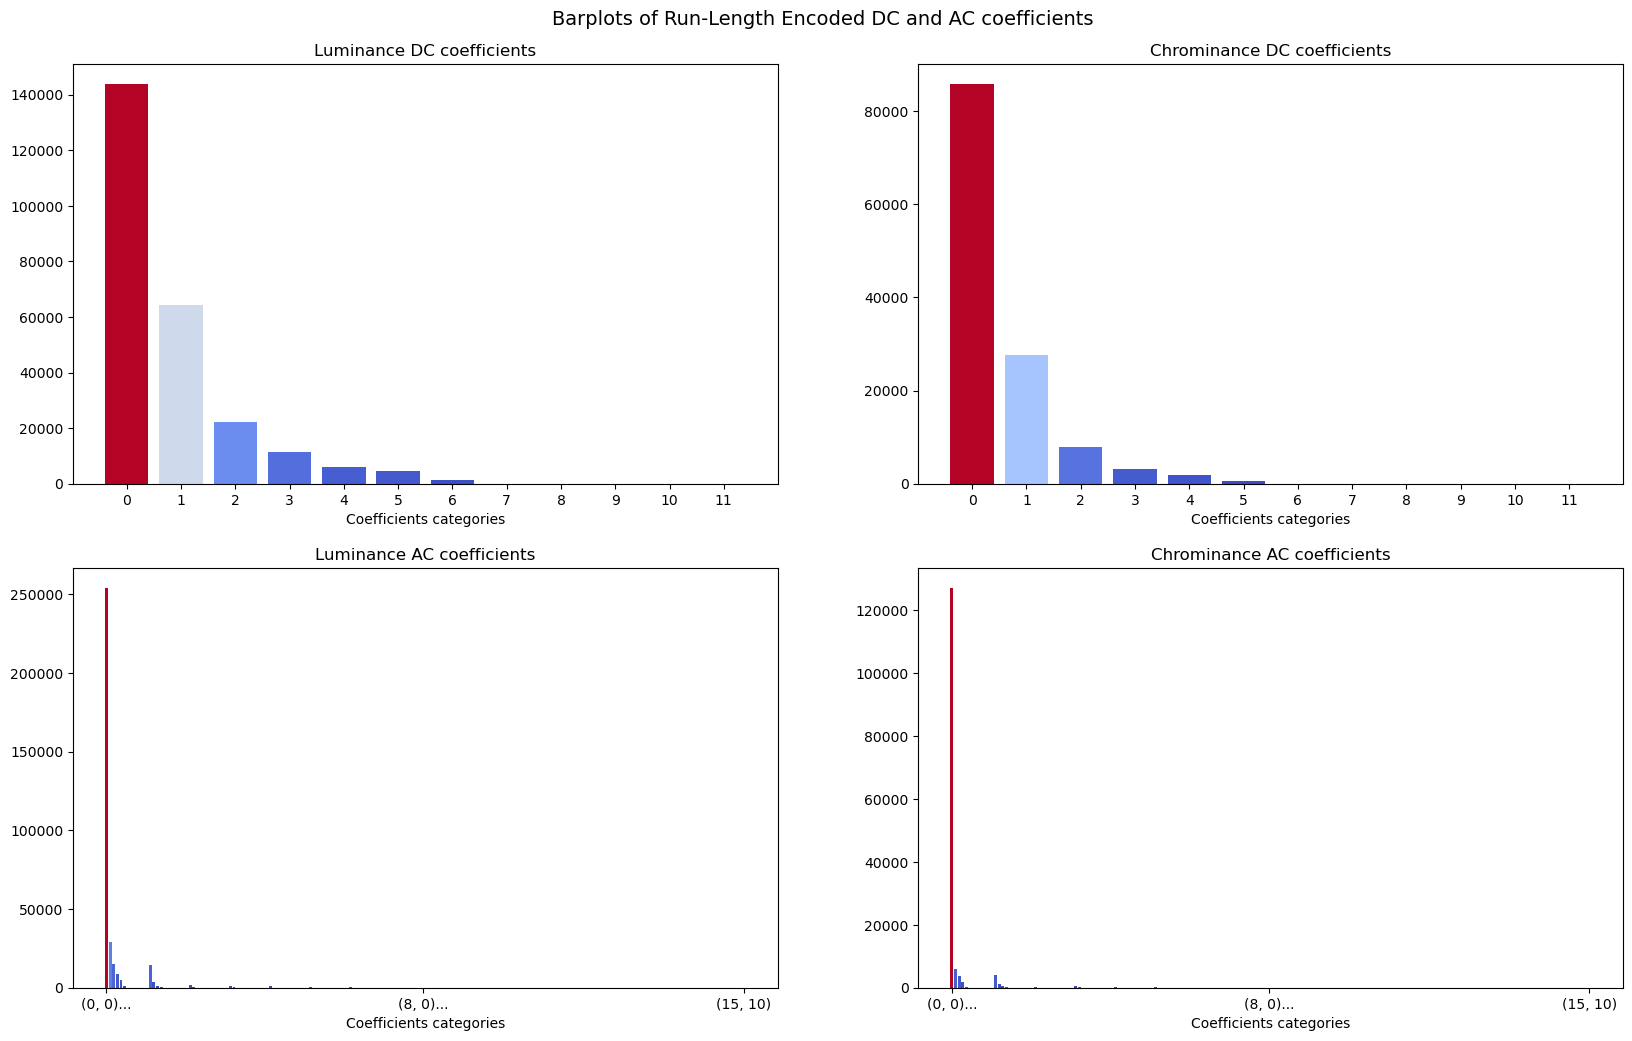

In [14]:
JPEG_encoder('img17.NEF', pad_technique = 'edge', quality = 'normal', custom_tables = True,
             show_metrics = True, show_tree_plots = True, show_freq_plots = True)

# Extras

We put below the code used for the plots presented in chapter $6$ of the presentation document

##### Plot for evaluating effects of different quantization levels (see simulation chapter)

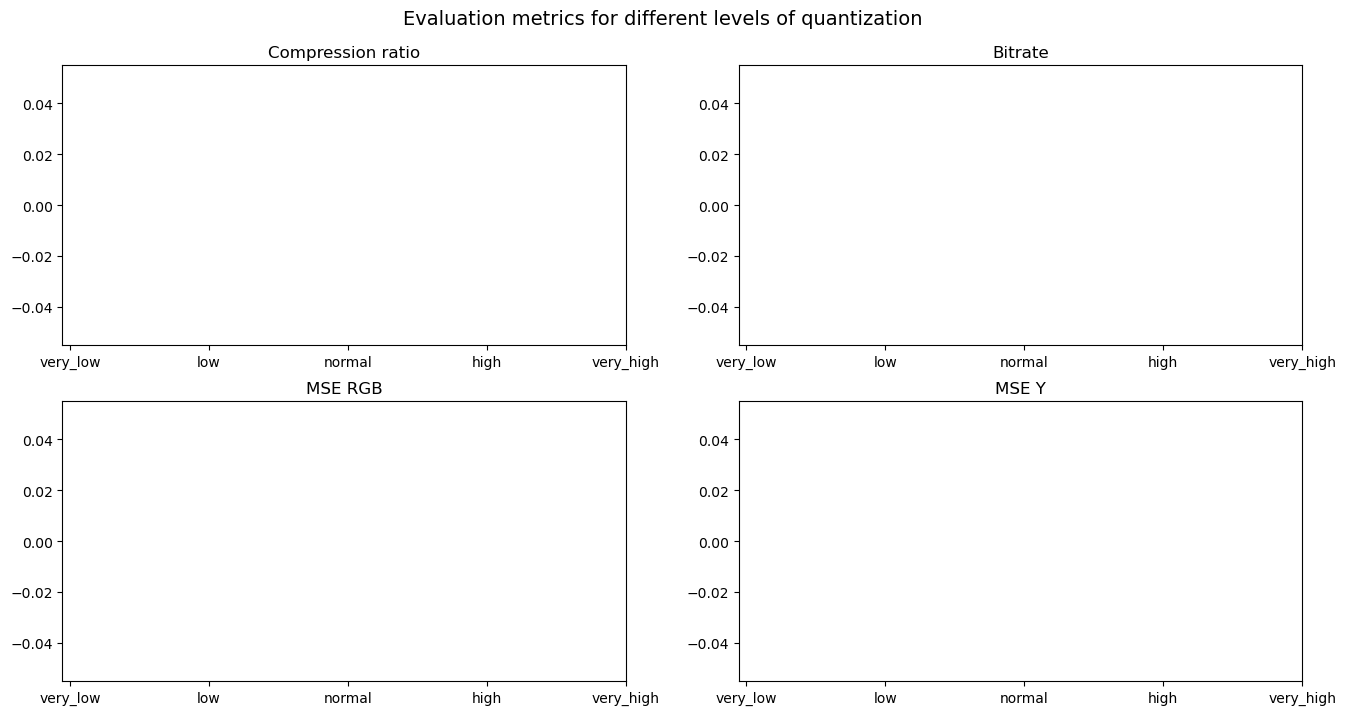

In [172]:
fig = plt.figure(figsize = (16, 8))
fig.suptitle('Evaluation metrics for different levels of quantization', y = .95, fontsize = 14)


ax1 = plt.subplot(221)
ax1.plot(comp_rat, 'D-.r')
plt.title('Compression ratio')
plt.xticks(range(0, 5), labels = ['very_low', 'low', 'normal', 'high', 'very_high'])

ax2 = plt.subplot(222)
ax2.plot(bitrt, 'D-.y')
plt.title('Bitrate')
plt.xticks(range(0, 5), labels = ['very_low', 'low', 'normal', 'high', 'very_high'])

ax3 = plt.subplot(223)
ax3.plot(mse_y, 'D-.g')
plt.title('MSE RGB')
plt.xticks(range(0, 5), labels = ['very_low', 'low', 'normal', 'high', 'very_high'])

ax4 = plt.subplot(224)
ax4.plot(mse_rgb, 'D-.m')
plt.title('MSE Y')
plt.xticks(range(0, 5), labels = ['very_low', 'low', 'normal', 'high', 'very_high'])

fig.savefig('quant_comparison.pdf')

##### Plot for evaluating effects standard vs. custom Huffman tables

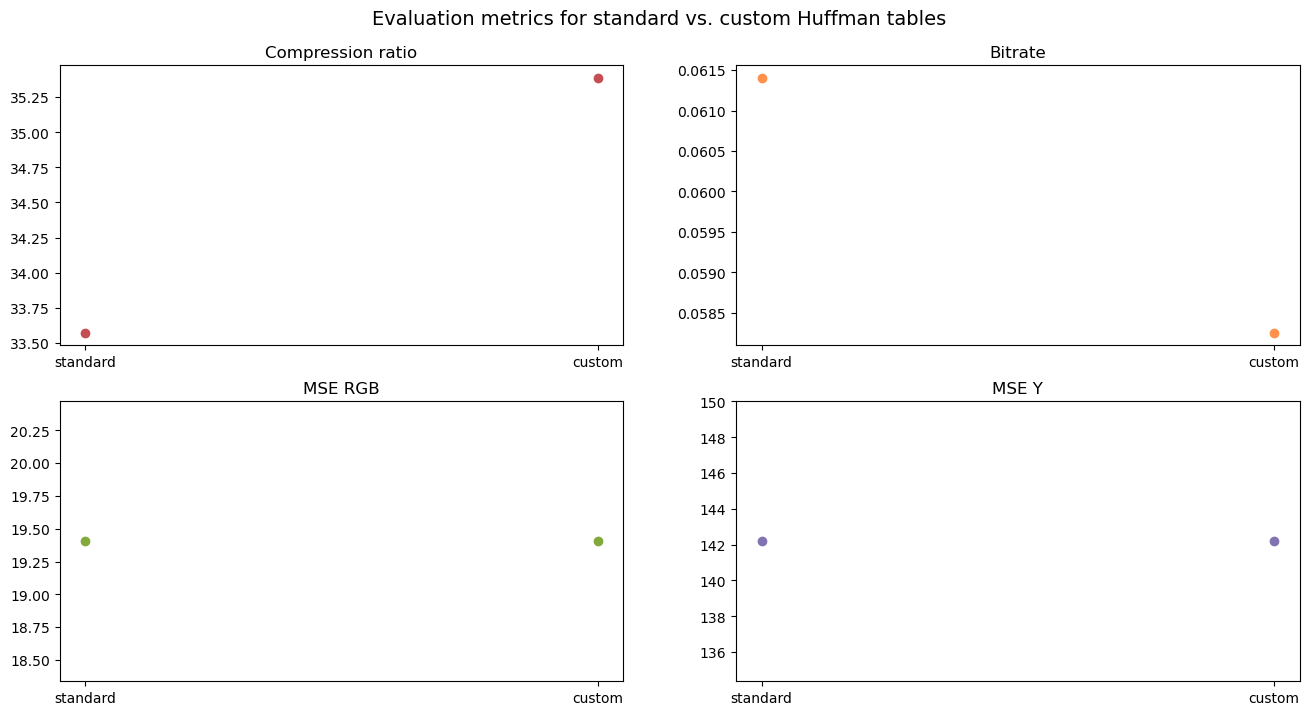

In [183]:
fig = plt.figure(figsize = (16, 8))
fig.suptitle('Evaluation metrics for standard vs. custom Huffman tables', y = .95, fontsize = 14)

ax1 = plt.subplot(221)
ax1.plot(comp_rat, 'ro')
plt.xticks(range(2), labels = ['standard', 'custom'])
plt.title('Compression ratio')

ax2 = plt.subplot(222)
ax2.plot(bitrt, 'yo')
plt.xticks(range(2), labels = ['standard', 'custom'])
plt.title('Bitrate')

ax3 = plt.subplot(223)
ax3.plot(mse_y, 'go')
plt.xticks(range(2), labels = ['standard', 'custom'])
plt.title('MSE RGB')

ax4 = plt.subplot(224)
ax4.plot(mse_rgb, 'mo')
plt.xticks(range(2), labels = ['standard', 'custom'])
plt.title('MSE Y')

fig.savefig('huff_comparison.pdf')

##### Evaluating empirically the encoder time complexity

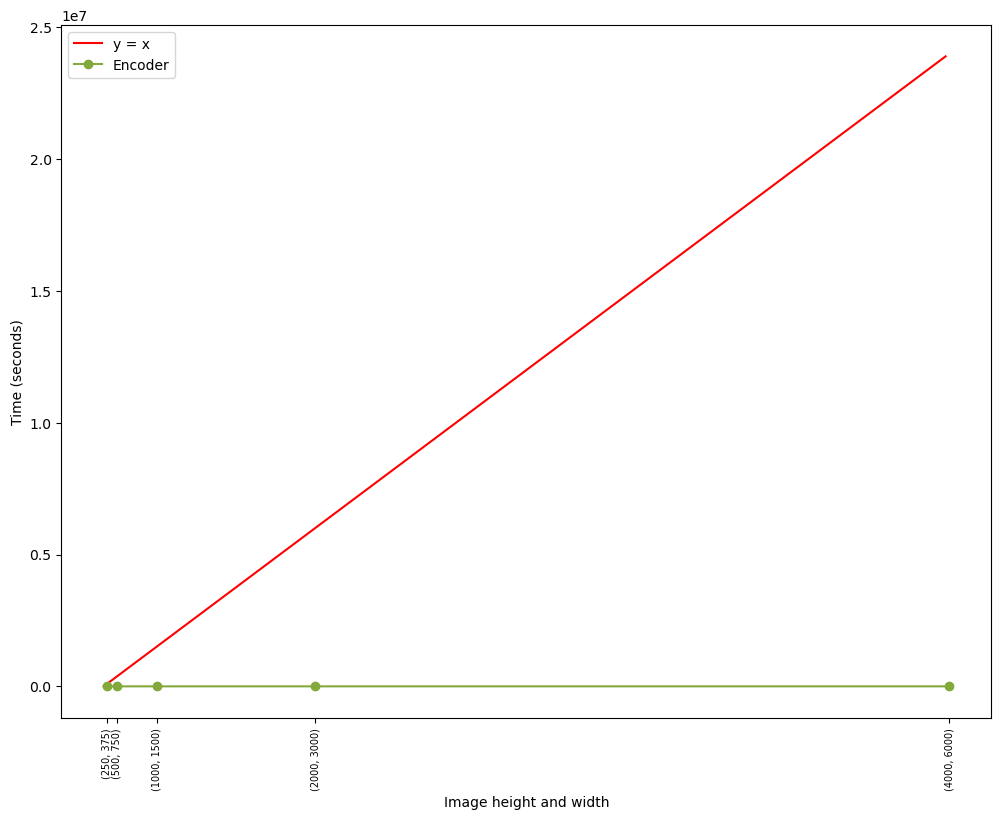

In [51]:
tot_pixels_plot = [element[0] * element[1] for element in tot_pixels]
plt.style.use('default')
fig = plt.figure(figsize = (12, 9))
ax = plt.subplot(111)
a = np.arange(0, tot_pixels_plot[-1], 100000)
b = a
ax.plot(a, b, label = 'y = x', color = 'red')
ax.plot(tot_pixels_plot, enc_time, 'o-g', label = 'Encoder')
plt.xticks(tot_pixels_plot, labels = tot_pixels, rotation = 90, fontsize = 7)
plt.xlabel('Image height and width')
plt.ylabel('Time (seconds)')
plt.legend()
fig.savefig('time_with_x_y.pdf')

##### Function used to evaluate space complexity + plotting of results

In [29]:
def run_jpeg_encoder(image):
    encoded_image = JPEG_encoder(image, pad_technique = 'edge', quality = 'normal', custom_tables = False,
             show_metrics = True, show_tree_plots = True, show_freq_plots = True)
    return encoded_image

In [30]:
#Reset variables
tot_pixels = []
max_mem = []

In [35]:
#Measure memory
mem_usage = memory_usage((run_jpeg_encoder, ('black_6000x4000.tif', )))
max_mem.append(max(mem_usage))

Image imported
Transformed color space from BGR to YCbCr
Chrominance subsampling applied! New dimensions are: (2000, 3000)
The new chrominance components shape is: (2000, 3000)
1:2 proportion re-established between luminance and downsampled chrominance components, new dimensions are: (4000, 6000)
Applied Discrete Cosine Transform to image components
Quantization process done
Zig-zagged components
Encoding process started
Encoding blocks
Writing file
Done! Time elapsed: 35.54444479942322s
### Metrics ###
Compression Ratio: 191.73
Mean squared Error (RGB): 12.0
Mean squared Error (Luminance): 4.0
Bitrate: 0.02


In [36]:
tot_pixels = tot_pixels[1:] #don't know why for the smallest image it happends the im. dim. two times

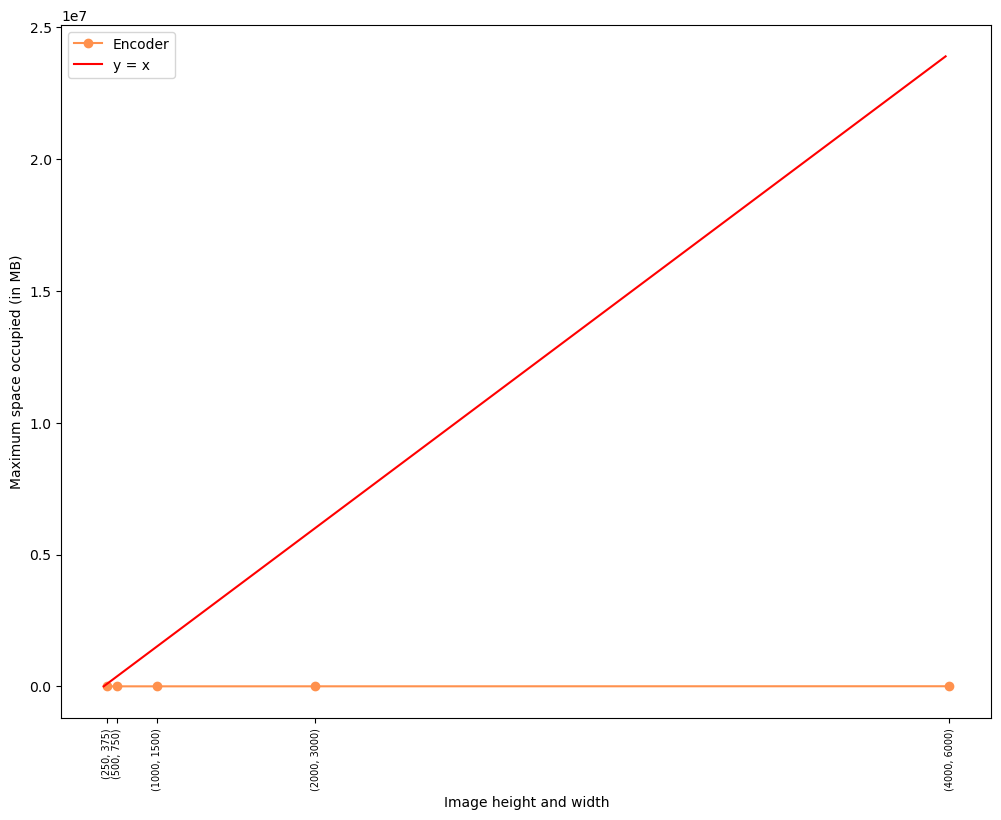

In [52]:
#Plotting
tot_pixels_plot = [element[0] * element[1] for element in tot_pixels]
fig = plt.figure(figsize = (12, 9))
ax = plt.subplot(111)
ax.plot(tot_pixels_plot, max_mem, 'o-y', label = 'Encoder')
a = np.arange(0, tot_pixels_plot[-1], 100000)
b = a
ax.plot(a, b, label = 'y = x', color = 'red')
plt.xticks(tot_pixels_plot, labels = tot_pixels, rotation = 90, fontsize = 7)
plt.xlabel('Image height and width')
plt.ylabel('Maximum space occupied (in MB)')
plt.legend()
fig.savefig('space_with_x_y.pdf')